In [22]:
(113 * 60 + 9) / 1297 * (1280+128-1297) / 60

9.68361603700848

# MCQ

In [36]:
import regex
import jsonlines
from collections import defaultdict
from string import punctuation

def load_jsonl(fname):
    with jsonlines.open(fname, mode='r') as reader:
        data = [l for l in reader]
    return data

def _extract_answer(gen):
    raw_gen = gen
    format_flag = False
    if 'QUESTION:' in gen:
        gen = gen.split('QUESTION:')[0]
    if ' answer is' in gen:
        gen = gen.strip().split(' answer is')[-1].strip().strip(punctuation).strip()
        format_flag = True
    elif 'Overall, ' in gen:
        gen = gen.strip().split('Overall, ')[-1].strip().strip(punctuation).strip()
        format_flag = True
    elif 'Answer: ' in gen:
        gen = gen.strip().split('Answer: ')[-1].strip().strip(punctuation).strip()
        format_flag = True
    elif 'Therefore, ' in gen:
        gen = gen.strip().split('Therefore, ')[-1].strip().strip(punctuation).strip()
        format_flag = True
    elif 'Thus, ' in gen:
        gen = gen.strip().split('Thus, ')[-1].strip().strip(punctuation).strip()
        format_flag = True
    elif 'So, ' in gen:
        gen = gen.strip().split('So, ')[-1].strip().strip(punctuation).strip()
        format_flag = True
    elif 'So ' in gen:
        gen = gen.strip().split('So ')[-1].strip().strip(punctuation).strip()
        format_flag = True
    elif '\n' in gen:
        gen = gen.strip().split('\n')[-1].strip().strip(punctuation).strip()
    
    options = regex.findall(r'\([A-Z1-9]\)|[A-Z1-9]\)', gen)
    options_backup = regex.findall(r'[A-Z1-9]', gen)
    if options:
        options = [x for i, x in enumerate(options) if x not in options[i+1:]]
        prediction = options[-1].strip(punctuation)
    elif options_backup and format_flag:
        options = [x for i, x in enumerate(options_backup) if x not in options_backup[i+1:]]
        prediction = options[-1].strip(punctuation)
    else:
        options = regex.findall(r'\([A-Z1-9]\)|[A-Z1-9]\)', raw_gen)
        if options:
            options = [x for i, x in enumerate(options) if x not in options[i+1:]]
            prediction = options[-1].strip(punctuation)
        else:
            prediction = None
    return prediction

def eval_accu(prediction, option, answer):    
    if isinstance(prediction, str):
        return _extract_answer(prediction) == option.strip(punctuation)
    else:
        counter = defaultdict(int)
        for g in prediction[:30]:
            g = _extract_answer(g)
            if g is not None:
                counter[g] += 1
        try:
            return max(counter.items(), key=lambda x: x[1])[0] == option.strip(punctuation)
        except:
            return False

def load_raw_labels(dtype, valtest=False):
    if valtest:
        raw_labels = load_jsonl(f'/home/users/nus/e0672129/scratch/csr/mcq_{dtype}_test.jsonl')
    else:
        raw_labels = load_jsonl(f'/home/users/nus/e0672129/scratch/csr/mcq_{dtype}_fulltest.jsonl')
    raw_labels_dict = {}
    for i, dt in enumerate(raw_labels):
        qu = (dt['question'].strip(), dt['answer'])
        raw_labels_dict[qu] = dt['label']
    return raw_labels_dict


In [37]:
from mcts_rl.configs.constants import COT_INSTRUCTIONS, PROMPT_BEGIN, PROMPT_ASSISTANT, PROMPT_USER, SQA_PROMPT

SQA_PROMPT = SQA_PROMPT.replace('</s>\n\n', ' ').replace('</s>', '').strip()

def extract_pred_result(raw_preds, dtype='default'):
    predictions, lens = {}, []
    if len(raw_preds) > 100:
        raw_preds = [raw_preds]
    for raw_pred in raw_preds:
        for dt in raw_pred:
            prompt = dt['prompt'][0].strip().replace(SQA_PROMPT, '').strip().replace(PROMPT_BEGIN, '').replace(PROMPT_USER, '').split(PROMPT_ASSISTANT)[0].strip()
            if dtype == 'mcts':
                generated = dt['generated'][-1][-1] if len(dt['generated']) else None
            else:
                generated = dt['generated'][0] if len(dt['generated']) == 1 else dt['generated']
            lens.append(len(dt['generated']))
            gt_answer = (dt['answer'], dt['answer_content'],)
            if prompt not in predictions:
                predictions[prompt] = {'pred': generated, 'gt_answer': gt_answer}
            elif isinstance(predictions[prompt]['pred'], list):
                predictions[prompt]['pred'] += generated
    return predictions

def visualize_pred_result(predictions, N=int(1e5), dtype='csr', show_split=False, valtest=False):
    raw_labels_dict = load_raw_labels(dtype, valtest=valtest)
    accu = []
    tsk_accu = None
    if dtype == 'sqa':
        tsk_accu = {x:[] for x in ['openbook', 'arc_easy', 'arc_hard', 'ai2s_ele', 'ai2s_mid']}
    elif dtype == 'csr':
        tsk_accu = {x:[] for x in ['csqa', 'siqa', 'piqa']}
    for prompt, gens in predictions.items():
        sft_gen = gens['pred']
        _eval = eval_accu(sft_gen, gens['gt_answer'][0], gens['gt_answer'][1])
        tsk = prompt.replace('QUESTION:', '').strip().split(PROMPT_ASSISTANT)[0].strip()
        tsk = (tsk, gens['gt_answer'][0])
        if tsk not in raw_labels_dict:
            continue
        if tsk_accu is not None and raw_labels_dict[tsk] not in tsk_accu:
            continue
        accu.append(_eval)
        if tsk_accu is not None:
            tsk_accu[raw_labels_dict[tsk]].append(_eval)
        if len(accu) >= N:
            break

    print('* all', sum(accu)/max(1, len(accu)), '({})'.format(len(accu)))
    if not show_split or tsk_accu is None:
        return
    for k, v in tsk_accu.items():
        print(k, sum(v)/max(1, len(v)), '({})'.format(len(v)))


## Prev Split

In [10]:
N = 19680
dtype = 'csr'
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/csr-cot/predictions/mcts-mistral-s512.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/csr-cot/predictions/mcts-mistral-s1280.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/csr-cot/predictions/mcts-mistral-s2048.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/csr-cot/predictions/mcts-mistral-s3072.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/csr-cot/predictions/mcts-mistral-s4096.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/csr-cot/predictions/mcts-mistral-s5120.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/csr-cot/predictions/mcts-mistral-s7424.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
print('---')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/csr-nodiv/predictions/mcts-mistral-s512.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/csr-nodiv/predictions/mcts-mistral-s1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/csr-nodiv/predictions/mcts-mistral-s1536.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/csr-nodiv/predictions/mcts-mistral-s2048.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/csr-nodiv/predictions/mcts-mistral-s2304.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)


* all 0.6544362908605738 (1499)
* all 0.7531687791861241 (1499)
* all 0.7378252168112075 (1499)
* all 0.7258172114743162 (1499)
* all 0.6924616410940627 (1499)
* all 0.7404936624416277 (1499)
* all 0.6390927284856571 (1499)
---
* all 0.6537691794529686 (1499)
* all 0.7484989993328885 (1499)
* all 0.733822548365577 (1499)
* all 0.7211474316210807 (1499)
* all 0.7111407605070047 (1499)


In [12]:
N = 19680
dtype = 'sqa'
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/sqa-cot/predictions/mcts-mistral-s512.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/sqa-cot/predictions/mcts-mistral-s1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/sqa-cot/predictions/mcts-mistral-s3328.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)

* all 0.7858166189111748 (1396)
* all 0.7979942693409742 (1396)
* all 0.7979942693409742 (1396)


## SQA

#### lr = 1e-6

In [31]:
N = 19680
dtype = 'sqa'
print('=== MCTS ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/sqa-noptx/predictions/mcts-mistral-s512.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/sqa-noptx/predictions/mcts-mistral-s1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/sqa-noptx/predictions/mcts-mistral-s2048.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/sqa-noptx/predictions/mcts-mistral-s3072.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/sqa-noptx/predictions/mcts-mistral-s4096.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/sqa-noptx/predictions/mcts-mistral-s2048-fulltest.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
print('=== SC ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/sqa-noptx-instance/predictions/s2816.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True,
)


=== MCTS ===
* all 0.7736389684813754 (1396)
* all 0.8116045845272206 (1396)
* all 0.833810888252149 (1396)
* all 0.8223495702005731 (1396)
* all 0.7858166189111748 (1396)
* all 0.8368030629337162 (4179)
=== SC ===
* all 0.8265135199808566 (4179)
openbook 0.766 (500)
arc_easy 0.8769462581617278 (1991)
arc_hard 0.733201581027668 (1012)
ai2s_ele 0.8576779026217228 (267)
ai2s_mid 0.8655256723716381 (409)


In [ ]:
N = 19680
dtype = 'sqa'
print('=== MCTS')
visualize_pred_result(
    extract_pred_result(
        [load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-512.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-1024.jsonl'),],
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        [load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-512.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-1024.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-1536.jsonl'),],
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        [load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-512.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-1024.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-1536.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-2048.jsonl'),],
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        [load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-512.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-1024.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-1536.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-2048.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-2560.jsonl'),],
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        [load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-512.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-1024.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-1536.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-2048.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-2560.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-3072.jsonl'),],
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        [load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-512.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-1024.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-1536.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-2048.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-2560.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-3072.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-4096.jsonl'),],
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)

In [35]:
N = 19680
dtype = 'sqa'
print('=== MCTS')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-512.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    # show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    # show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-1536.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    # show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-2048.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    # show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-2560.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    # show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-3072.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    # show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/mcts-4096.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
print('=== SC')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/sc-512.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/sc-1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/sc-1536.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/sc-2048.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/sc-2816.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/sc-3072.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)


=== MCTS
* all 0.8018664752333095 (4179)
* all 0.8274706867671692 (4179)
* all 0.8267528116774348 (4179)
* all 0.8368030629337162 (4179)
* all 0.8394352715960757 (4179)
* all 0.8322565206987318 (4179)
* all 0.7946877243359656 (4179)
=== SC
* all 0.7422828427853554 (4179)
openbook 0.67 (500)
arc_easy 0.77850326469111 (1991)
arc_hard 0.6650197628458498 (1012)
ai2s_ele 0.8089887640449438 (267)
ai2s_mid 0.8019559902200489 (409)
* all 0.8006700167504187 (4179)
openbook 0.75 (500)
arc_easy 0.8317428427925665 (1991)
arc_hard 0.724308300395257 (1012)
ai2s_ele 0.8951310861423221 (267)
ai2s_mid 0.8386308068459658 (409)
* all 0.79923426657095 (4179)
openbook 0.72 (500)
arc_easy 0.8382722250125565 (1991)
arc_hard 0.7223320158102767 (1012)
ai2s_ele 0.8913857677902621 (267)
ai2s_mid 0.8361858190709046 (409)
* all 0.7989949748743719 (4179)
openbook 0.724 (500)
arc_easy 0.8342541436464088 (1991)
arc_hard 0.7213438735177866 (1012)
ai2s_ele 0.8726591760299626 (267)
ai2s_mid 0.863080684596577 (409)
* all

#### lr = 4e-7

0.8756202913108991
0.7392588932806323
0.8998127340823969
0.8520782396088018

In [110]:
def cal(s1, s2, s3, delta=0.99):
    _max = max(s1, s2)
    _min = min(s1, s2)
    s = _min - (_max - _min)
    s = delta * s + (1 - delta) * s3
    print(s)

cal(0.873, 0.873, 0.018)

0.8644499999999999


In [30]:
N = 7000
dtype = 'sqa'
print('=== SQA ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/direct-e1.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    # show_split=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/sft.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    # show_split=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/direct-e2.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    # show_split=True,
)
print('=== SciQ ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/sciq-direct-e1.jsonl'),
        dtype='sciq',
    ),
    dtype='sciq',
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/xsciq-direct-e1.jsonl'),
        dtype='sciq',
    ),
    dtype='sciq',
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/sciq-direct-e2.jsonl'),
        dtype='sciq',
    ),
    dtype='sciq',
    N=N,
    valtest=True,
)
print('=== CSR ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/direct-e1.jsonl'),
        dtype='csr',
    ),
    dtype='csr',
    N=N,
    # show_split=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/xdirect-e1.jsonl'),
        dtype='csr',
    ),
    dtype='csr',
    N=N,
    # show_split=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/direct-e2.jsonl'),
        dtype='csr',
    ),
    dtype='csr',
    N=N,
    # show_split=True,
)


=== SQA ===
* all 0.8535534816941852 (4179)
* all 0.6652309164871979 (4179)
* all 0.8547499401770758 (4179)
=== SciQ ===
* all 0.018 (1000)
* all 0.873 (1000)
* all 0.873 (1000)
=== CSR ===
* all 0.11086607858861267 (4988)
* all 0.7949077786688051 (4988)
* all 0.8167602245388933 (4988)
csqa 0.7960687960687961 (1221)
siqa 0.7829015544041451 (1930)
piqa 0.8660860097985846 (1837)


In [23]:
N = 3168
dtype = 'sqa'
visualize_pred_result(
    extract_pred_result(
        [load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/sc20-arithmo.jsonl'),
         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/base-sc.jsonl')],
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)

* all 0.8096590909090909 (3168)


In [4]:
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/sft.jsonl'),
        dtype='sqa',
    ),
    dtype='sqa',
    N=50000,
    show_split=True,
)

* all 0.6652309164871979 (4179)
openbook 0.598 (500)
arc_easy 0.6921145153189352 (1991)
arc_hard 0.6057312252964426 (1012)
ai2s_ele 0.7490636704119851 (267)
ai2s_mid 0.7090464547677262 (409)


In [22]:
N = 13190
dtype = 'sqa'
print('=== Baseline ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/arithmo-cot.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    valtest=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/sft.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    # show_split=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/few-shot-arithmo.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/sc20-arithmo.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/base-sc.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
print('=== MCTS (on-policy) ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/mistral-online-mcts-s1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/mistral-online-mcts-s2048.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
# visualize_pred_result(
#     extract_pred_result(
#         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/mistral-online-mcts-s2560.jsonl'),
#         dtype=dtype,
#     ),
#     dtype=dtype,
#     N=N,
# )
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/mistral-online-mcts-s3072.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
# visualize_pred_result(
#     extract_pred_result(
#         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/mistral-online-mcts-s3456.jsonl'),
#         dtype=dtype,
#     ),
#     dtype=dtype,
#     N=N,
# )
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/mistral-online-mcts-s3840.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/mistral-online-mcts-s5760.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
print('-')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/rd-mistral-online-mcts-s1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/rd-mistral-online-mcts-s2048.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/rd-mistral-online-mcts-s2688.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)


=== Baseline ===
* all 0.6568767908309455 (1396)
* all 0.6652309164871979 (4179)
* all 0.805087782156933 (2791)
* all 0.8030629337162001 (4179)
* all 0.8025843503230438 (4179)
=== MCTS (on-policy) ===
* all 0.7793730557549653 (4179)
* all 0.797559224694903 (4179)
* all 0.7032782962431203 (4179)
* all 0.7429768358797437 (4058)
* all 0.780282536819958 (3327)
openbook 0.691358024691358 (405)
arc_easy 0.8250471994965387 (1589)
arc_hard 0.694829760403531 (793)
ai2s_ele 0.8372093023255814 (215)
ai2s_mid 0.8430769230769231 (325)
-
* all 0.8013878918401531 (4179)
openbook 0.73 (500)
arc_easy 0.8402812656956303 (1991)
arc_hard 0.717391304347826 (1012)
ai2s_ele 0.898876404494382 (267)
ai2s_mid 0.843520782396088 (409)
* all 0.7881559942224362 (4154)
* all 0.7308641975308642 (2025)


In [88]:
N = 13190
dtype = 'csr'
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/sqa-ipo-s1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)

* all 0.6734397677793904 (689)
csqa 0.6931818181818182 (176)
siqa 0.572 (250)
piqa 0.7566539923954373 (263)


In [34]:
N = 13190
dtype = 'sqa'
print('=== MCTS (on-policy IPO) ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/ipo-mistral-online-mcts-s128x.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    # show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/ipo-mistral-online-mcts-s512.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/ipo-mistral-online-mcts-s1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    # show_split=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/ipo-mistral-online-mcts-s1536.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/ipo-mistral-online-mcts-s2048.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/ipo-mistral-online-mcts-s2432.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    # show_split=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/ipo-mistral-online-mcts-s2816.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    # show_split=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/ipo-mistral-online-mcts-s3200.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    # show_split=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/ipo-mistral-online-mcts-s3584.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    # show_split=True,
)
print('=== MCTS (off-policy) ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/mistral-offline-mcts-s1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/mistral-offline-mcts-s2048.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/mistral-offline-mcts-s2816.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
print('=== SC (on-policy) ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/mistral-online-sc-s2048.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)


=== MCTS (on-policy IPO) ===
* all 0.6738454175640105 (4179)
* all 0.7552045944005743 (4179)
* all 0.8068916008614501 (4179)
* all 0.7681263460157932 (4179)
* all 0.7642976788705432 (4179)
* all 0.8042593921990907 (4179)
* all 0.8042593921990907 (4179)
* all 0.7966020579085906 (4179)
* all 0.7846374730796841 (4179)
=== MCTS (off-policy) ===
* all 0.7788944723618091 (4179)
* all 0.7160493827160493 (2754)
* all 0.7004067958841829 (4179)
=== SC (on-policy) ===
* all 0.7829624312036373 (4179)


#### MCTS

In [470]:
N = 29660
dtype = 'sqa'
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/mcts/sft.jsonl'),
        dtype='mcts',
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
print('=== w/o ground-truth ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/mcts/sft-nogt.jsonl'),
        dtype='mcts',
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
print('=== w/o self-eval ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/mcts/sft-noeval.jsonl'),
        dtype='mcts',
    ),
    dtype=dtype,
    N=N,
    show_split=True
)


* all 0.8636037329504667 (4179)
openbook 0.826 (500)
arc_easy 0.88598694123556 (1991)
arc_hard 0.825098814229249 (1012)
ai2s_ele 0.898876404494382 (267)
ai2s_mid 0.8728606356968215 (409)
=== w/o ground-truth ===
* all 0.674802584350323 (4179)
openbook 0.58 (500)
arc_easy 0.7112004018081366 (1991)
arc_hard 0.6215415019762845 (1012)
ai2s_ele 0.7191011235955056 (267)
ai2s_mid 0.7163814180929096 (409)
=== w/o self-eval ===
* all 0.8726968174204355 (4179)
openbook 0.816 (500)
arc_easy 0.8955298844801607 (1991)
arc_hard 0.8300395256916996 (1012)
ai2s_ele 0.9213483146067416 (267)
ai2s_mid 0.9046454767726161 (409)


#### SciQA

In [4]:
N = 8800
dtype = 'sciq'
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/sciq-sft.jsonl'),
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/sciq-mistral-online-mcts-s2048.jsonl'),
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/sciq-mistral-online-mcts-s5888.jsonl'),
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/sciq-prev-s2048.jsonl'),
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/sqa-noptx/predictions/mcts-mistral-s2048-sciq.jsonl'),
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/sqa-noptx/predictions/mcts-mistral-s3072-sciq.jsonl'),
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
print('=== IPO ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/sciq-ipo-mistral-online-mcts-s1024.jsonl'),
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/sciq-ipo-mistral-online-mcts-s2048.jsonl'),
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/sciq-ipo-mistral-online-mcts-s2432.jsonl'),
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/sciq-ipo-mistral-online-mcts-s3072.jsonl'),
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)


* all 0.808 (1000)
* all 0.86 (1000)
* all 0.856 (1000)
* all 0.876 (1000)
* all 0.876 (1000)
* all 0.885 (1000)
=== IPO ===
* all 0.888 (1000)
* all 0.865 (1000)
* all 0.883 (1000)
* all 0.877 (1000)


## CSR

In [23]:
N = 19680
dtype = 'csr'
print('=== MCTS')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/csr-1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/csr-2048.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/csr-3072.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/csr-4096.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/csr-5120.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)


=== MCTS
* all 0.6000400962309543 (4988)
* all 0.7285485164394547 (4988)
csqa 0.7215397215397216 (1221)
siqa 0.6642487046632124 (1930)
piqa 0.8007621121393577 (1837)
* all 0.7143143544506816 (4988)
csqa 0.6994266994266994 (1221)
siqa 0.6580310880829016 (1930)
piqa 0.7833424060968971 (1837)
* all 0.665196471531676 (4988)
csqa 0.714987714987715 (1221)
siqa 0.6689119170984456 (1930)
piqa 0.628198149156233 (1837)
* all 0.748195669607057 (4988)
csqa 0.733005733005733 (1221)
siqa 0.6870466321243524 (1930)
piqa 0.8225367446924333 (1837)


#### lr = 1e-6

In [19]:
N = 6640
dtype = 'csr'
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/csr-1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/csr-2048.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/csr-3072.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/csr-4096.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/csr-5120.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/csr-5376.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True,
)
print('-')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/predictions/csr-sqa-3072.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)


* all 0.6000400962309543 (4988)
csqa 0.6683046683046683 (1221)
siqa 0.6139896373056994 (1930)
piqa 0.5400108873162766 (1837)
* all 0.7285485164394547 (4988)
csqa 0.7215397215397216 (1221)
siqa 0.6642487046632124 (1930)
piqa 0.8007621121393577 (1837)
* all 0.7143143544506816 (4988)
csqa 0.6994266994266994 (1221)
siqa 0.6580310880829016 (1930)
piqa 0.7833424060968971 (1837)
* all 0.665196471531676 (4988)
csqa 0.714987714987715 (1221)
siqa 0.6689119170984456 (1930)
piqa 0.628198149156233 (1837)
* all 0.748195669607057 (4988)
csqa 0.733005733005733 (1221)
siqa 0.6870466321243524 (1930)
piqa 0.8225367446924333 (1837)
* all 0.7231355252606255 (4988)
csqa 0.7321867321867321 (1221)
siqa 0.6844559585492228 (1930)
piqa 0.7577572128470332 (1837)
-
* all 0.7047430830039526 (2530)
csqa 0.6640866873065016 (646)
siqa 0.6631908237747653 (959)
piqa 0.7762162162162162 (925)


In [46]:
N = 6640
dtype = 'csr'
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/csr-noptx/predictions/mcts-mistral-s1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/csr-noptx/predictions/mcts-mistral-s2048.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/csr-noptx/predictions/mcts-mistral-s3072.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/csr-noptx/predictions/mcts-mistral-s4096.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/csr-noptx/predictions/mcts-mistral-s5120.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/csr-noptx/predictions/mcts-mistral-s5120-fulltest.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)


* all 0.7184789859906604 (1499)
* all 0.7471647765176784 (1499)
* all 0.7451634422948632 (1499)
* all 0.7498332221480988 (1499)
* all 0.7558372248165444 (1499)
* all 0.748195669607057 (4988)
csqa 0.733005733005733 (1221)
siqa 0.6870466321243524 (1930)
piqa 0.8225367446924333 (1837)


In [135]:
N = 29050
dtype = 'csr'
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/sc20-arithmo.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True,
)

* all 0.6744186046511628 (4988)
csqa 0.6363636363636364 (1221)
siqa 0.6341968911917099 (1930)
piqa 0.7419706042460533 (1837)


In [9]:
N = 34900
dtype = 'nli'
show_split = False
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/nli-rd-mistral-online-mcts-s1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=show_split,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/nli-mistral-online-mcts-s4096.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=show_split,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/nli-mistral-online-mcts-s4608.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=show_split,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/mcq/csr-noptx/predictions/mcts-mistral-s5120-nli.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=show_split,
    valtest=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/nli-ipo-mistral-online-mcts-s1536.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=show_split,
    valtest=True,
)


* all 0.6814621409921671 (1532)
* all 0.6390339425587467 (1532)
* all 0.6664490861618799 (1532)
* all 0.7180156657963447 (1532)
* all 0.6775456919060052 (1532)


In [5]:
N = 34900
dtype = 'csr'
show_split = True
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/sqa-ipo-s1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=show_split,
)


* all 0.6701807228915663 (664)
csqa 0.6964285714285714 (168)
siqa 0.5661157024793388 (242)
piqa 0.7519685039370079 (254)


In [5]:
N = 34900
dtype = 'csr'
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/sft.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True,
)

* all 0.6018444266238974 (4988)
csqa 0.5405405405405406 (1221)
siqa 0.6031088082901555 (1930)
piqa 0.6412629286880784 (1837)


In [25]:
N = 34900
dtype = 'csr'
show_split = True
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/sft.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
print('=== online mcts ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/mistral-online-mcts-s1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/mistral-online-mcts-s2048.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/mistral-online-mcts-s3072.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
   show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/mistral-online-mcts-s3968.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/mistral-online-mcts-s4608.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True
)
print('=== online mcts (random) ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/rd-mistral-online-mcts-s1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=show_split,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/rd-mistral-online-mcts-s2048.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True,
)
print('=== offline mcts ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/mistral-offline-mcts-s1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=show_split,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/mistral-offline-mcts-s1792.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/mistral-offline-mcts-s2304.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True,
)
print('=== online sc ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/mistral-online-sc-s1536.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/mistral-online-sc-s2048.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=show_split,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/mistral-online-sc-s2816.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
    show_split=True,
)
print('=== IPO ===')
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/ipo-mistral-online-mcts-s512.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/ipo-mistral-online-mcts-s1024.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/ipo-mistral-online-mcts-s1280.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)
visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/csr/predictions/ipo-mistral-online-mcts-s1664.jsonl'),
        dtype=dtype,
    ),
    dtype=dtype,
    N=N,
)


* all 0.6018444266238974 (4988)
csqa 0.5405405405405406 (1221)
siqa 0.6031088082901555 (1930)
piqa 0.6412629286880784 (1837)
=== online mcts ===
* all 0.6988773055332799 (4988)
csqa 0.6535626535626535 (1221)
siqa 0.6404145077720207 (1930)
piqa 0.7904191616766467 (1837)
* all 0.6862469927826784 (4988)
csqa 0.6822276822276823 (1221)
siqa 0.6108808290155441 (1930)
piqa 0.7681001633097442 (1837)
* all 0.6858460304731355 (4988)
csqa 0.6732186732186732 (1221)
siqa 0.5979274611398964 (1930)
piqa 0.7866086009798585 (1837)
* all 0.7111066559743384 (4988)
csqa 0.6756756756756757 (1221)
siqa 0.6450777202072538 (1930)
piqa 0.804028307022319 (1837)
* all 0.7076984763432237 (4988)
csqa 0.6805896805896806 (1221)
siqa 0.644559585492228 (1930)
piqa 0.7920522591181274 (1837)
=== online mcts (random) ===
* all 0.7143143544506816 (4988)
csqa 0.7018837018837019 (1221)
siqa 0.6585492227979275 (1930)
piqa 0.7811649428415895 (1837)
* all 0.7215316760224539 (4988)
csqa 0.6986076986076986 (1221)
siqa 0.66787564

# ARITHMO

In [4]:
import jsonlines
from string import punctuation

def load_jsonl(fname):
    with jsonlines.open(fname, mode='r') as reader:
        data = [l for l in reader]
    return data

In [5]:
from collections import defaultdict
from mcts_rl.utils import extract_answer, math_equal
from mcts_rl.configs.constants import COT_INSTRUCTIONS, PROMPT_BEGIN, PROMPT_ASSISTANT, PROMPT_USER

def extract_pred_result(raw_pred, dtype='default'):
    predictions, lens = {}, []
    for dt in raw_pred:
        prompt = dt['prompt'][0].strip().replace(PROMPT_BEGIN, '').replace(PROMPT_USER, '').replace(PROMPT_ASSISTANT, '').strip()
        if dtype == 'mcts':
            generated = dt['generated'][-1][-1] if len(dt['generated']) else None
        else:
            generated = dt['generated'][0] if len(dt['generated']) == 1 else dt['generated']
        lens.append(len(dt['generated']))
        gt_answer = (dt['answer'], dt['answer_content'],)
        if prompt in predictions: continue
        predictions[prompt] = {'pred': generated, 'gt_answer': gt_answer}
    avg_lens = sum(lens) / len(lens)
    if avg_lens > 1:
        lens.sort()
        print(avg_lens, lens[len(lens)//2])
    return predictions

def extract_sc_answer(gens, use_code=False, k=100):
    preds = [extract_answer(g, use_code=use_code) for g in gens[:k]]
    counter = defaultdict(int)
    for p in preds:
        counter[p] += 1
    return max(counter.items(), key=lambda x: x[1])[0]

def visualize_pred_result(predictions, N=int(1e5), use_code=False, k=100):
    accu, errors, idx = [], [], -1
    for prompt, gens in predictions.items():
        idx += 1
        sft_gen = gens['pred']
        pred = extract_answer(sft_gen, use_code=use_code) if isinstance(sft_gen, str) else extract_sc_answer(sft_gen, use_code=use_code, k=k)
        correct = math_equal(pred, gens['gt_answer'][0])
        if '\nAnswer Choices: ' in prompt:
            options = prompt.split('\nAnswer Choices: ')[-1].replace('Write a Python program to solve this.', '').strip()
            option = options.split(f"({gens['gt_answer'][0]})")[-1].split(' (')[0].strip()
            correct = correct or (math_equal(pred, option))
            gens['option_content'] = option
        gens['index'] = idx
        gens['prompt'] = prompt
        gens['pred_rst'] = pred
        gens['correct'] = correct
        errors.append(gens)
        accu.append(correct)

    print('all', sum(accu[:N])/max(1, len(accu[:N])), '({})'.format(len(accu[:N])))
    return errors


## MATH

In [3]:
N = 11090
print('=== baseline ===')
base_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/math-sft-e1.jsonl'),
    ),
    N=N,
)
base_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/sc-math-sft-e1.jsonl'),
    ),
    N=N,
)
base_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/math-sft-e2.jsonl'),
    ),
    N=N,
)
base_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/math-sft.jsonl'),
    ),
    N=N,
)
print('=== online mcts IPO ===')
base_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/math-ipo-mistral-online-mcts-s1408.jsonl'),
    ),
    N=N,
)
base_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/math-e2-ipo-mistral-online-mcts-s128.jsonl'),
    ),
    N=N,
)
print('=== online mcts ===')
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/math-wide-mistral-online-mcts-s1024.jsonl'),
    ),
    N=N,
)
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/math-mistral-online-mcts-s1536.jsonl'),
    ),
    N=N,
)
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/math-mistral-online-mcts-s1792.jsonl'),
    ),
    N=N,
)
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/math-e2-d3-math-mistral-online-mcts-s384.jsonl'),
    ),
    N=N,
)
print('-')
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/math-e2-mistral-online-mcts-s256.jsonl'),
    ),
    N=N,
)
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/math-e2-mistral-online-mcts-s640.jsonl'),
    ),
    N=N,
)


=== baseline ===


/home/users/nus/e0672129/.conda/envs/safe-rlhf-copy/lib/python3.10/site-packages/sympy/parsing/latex/_parse_latex_antlr.py:23: UserWarning: antlr4.error.ErrorListener module is not installed
  ErrorListener = import_module('antlr4.error.ErrorListener',


all 0.2644528905781156 (4999)
10.0 10
all 0.28554846198491 (3446)
all 0.28945789157831564 (4999)


/home/users/nus/e0672129/.conda/envs/safe-rlhf-copy/lib/python3.10/site-packages/sympy/sets/sets.py:1929: SymPyDeprecationWarning: 

The string fallback in sympify() is deprecated.

To explicitly convert the string form of an object, use
sympify(str(obj)). To add define sympify behavior on custom
objects, use sympy.core.sympify.converter or define obj._sympy_
(see the sympify() docstring).

sympify() performed the string fallback resulting in the following string:

'<function N at 0x7f036c2e23b0>'

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympify-string-fallback
for details.

This has been deprecated since SymPy version 1.6. It
will be removed in a future version of SymPy.

  args = list(map(sympify, args))
/home/users/nus/e0672129/.conda/envs/safe-rlhf-copy/lib/python3.10/site-packages/sympy/core/evalf.py:1749: SymPyDeprecationWarning: 

The string fallback in sympify() is deprecated.

To explicitly convert the string form of an object, use
sym

all 0.3074614922984597 (4999)
=== online mcts IPO ===
all 0.30798479087452474 (263)


/home/users/nus/e0672129/.conda/envs/safe-rlhf-copy/lib/python3.10/site-packages/sympy/core/evalf.py:1749: SymPyDeprecationWarning: 

The string fallback in sympify() is deprecated.

To explicitly convert the string form of an object, use
sympify(str(obj)). To add define sympify behavior on custom
objects, use sympy.core.sympify.converter or define obj._sympy_
(see the sympify() docstring).

sympify() performed the string fallback resulting in the following string:

'<built-in function any>'

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympify-string-fallback
for details.

This has been deprecated since SymPy version 1.6. It
will be removed in a future version of SymPy.

  return sympify(x, rational=True).evalf(n, **options)


all 0.28343023255813954 (1376)
=== online mcts ===
all 0.3151750972762646 (1028)
all 0.3178155774395703 (1117)
all 0.31420765027322406 (1098)
all 0.2813975448536355 (1059)
-
all 0.2831275720164609 (1215)
all 0.2966593318663733 (4999)


## AQuA

In [37]:
N = 1650
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/aqua-sft.jsonl'),
    ),
    N=N,
)
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/aqua-mistral-online-sc-s1024.jsonl'),
    ),
    N=N,
)
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/aqua-wide-mistral-online-mcts-s1024.jsonl'),
    ),
    N=N,
)
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/sqa/predictions/aqua-rd-mistral-online-mcts-s1024.jsonl'),
    ),
    N=N,
)

all 0.48031496062992124 (254)
all 0.468503937007874 (254)
all 0.46062992125984253 (254)
all 0.41338582677165353 (254)


In [6]:
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/aqua-sft.jsonl'),
    ),
    N=N,
    use_code=True,
)
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/aqua-mistral-online-mcts-s2560.jsonl'),
    ),
    N=N,
    use_code=True,
)


all 0.2637795275590551 (254)
all 0.2637795275590551 (254)


## GSM8K

In [140]:
from datasets import load_dataset

data = load_dataset('keirp/hungarian_national_hs_finals_exam')

In [121]:
data['test'][0].keys()

dict_keys(['Question'])

In [4]:
N = 25000
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/sft/llama2-arithmo/predictions/sft-s8403.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/sft/llama2-arithmo/predictions/sft-s16806.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/sft/llama2-arithmo/predictions/sft-s25209.jsonl'),
    ),
    N=N,
)
print('===')
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/sft/diymistral-arithmo/predictions/sft-s4202-gsm8k.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/sft/diymistral-arithmo/predictions/sft-s8404-gsm8k.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/sft/diymistral-arithmo/predictions/sft-s8404-math.jsonl'),
    ),
    N=N,
)
print('===')
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/sft/diymistral-arithmo-lowerlr/predictions/gsm-cot.jsonl'),
    ),
    N=N,
)


all 0.6459438968915845 (1319)
all 0.6557998483699773 (1319)
all 0.6800606520090978 (1319)
===
all 0.6467020470053071 (1319)
all 0.714177407126611 (1319)


<string>:1: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?


all 0.2606521304260852 (4999)
===
all 0.7589082638362395 (1319)


#### CoT

In [7]:
N = 7000

rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/sft/diymistral-arithmo-lowerlr/predictions/gsm-cot.jsonl'),
    ),
    N=N,
)
print('=== IPO')
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/e2-ipo-mistral-online-mcts-s128.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/sc-e2-ipo-mistral-online-mcts-s128.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/ipo-mistral-online-mcts-s1408.jsonl'),
    ),
    N=N,
)
print('=== DPO')
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/e2-gsm8k-mistral-online-mcts-s128.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/e2-gsm8k-mistral-online-mcts-s256.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/e2-gsm8k-mistral-online-mcts-s512.jsonl'),
    ),
    N=N,
)
print('-')
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/e2-gsm8k-mistral-offline-mcts-s128.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/e2-gsm8k-mistral-offline-mcts-s640.jsonl'),
    ),
    N=N,
)
print('-')
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/e2-mistral-online-mcts-s256.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/e2-mistral-online-mcts-s384.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/e2-mistral-online-mcts-s512.jsonl'),
    ),
    N=N,
)
print('-')
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/e1-bw-mathqa-mistral-online-mcts-s512.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/e1-bw-mathqa-mistral-online-mcts-s512.jsonl'),
    ),
    N=N,
    use_code=True
)


all 0.7589082638362395 (1319)
=== IPO
all 0.7748294162244125 (1319)
20.0 20
all 0.863275039745628 (629)
all 0.7378048780487805 (164)
=== DPO
all 0.7695223654283548 (1319)
all 0.7717968157695224 (1319)
all 0.7604245640636846 (1319)
-
all 0.7710386656557998 (1319)
all 0.7543593631539045 (1319)
-
all 0.7680060652009097 (1319)
all 0.7733131159969674 (1319)
all 0.77710386656558 (1319)
-
all 0.7391963608794542 (1319)
all 0.7498104624715694 (1319)


In [45]:
N = 4500

print('=== Baseline ===')
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/sft/diymistral-arithmo-lowerlr/predictions/e1-gsm-cot.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/sft/diymistral-arithmo-lowerlr/predictions/gsm-cot.jsonl'),
    ),
    N=N,
)
fs_rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/sc-gsm8k-sft.jsonl'),
    ),
    N=N,
    k=10
)
print('=== MCTS (on-policy) ===')
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mistral-online-mcts-s1024.jsonl'),
    ),
    N=N,
)
# rst = visualize_pred_result(
#     extract_pred_result(
#         load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/wide-mistral-online-mcts-s1408.jsonl'),
#     ),
#     N=N,
# )
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mistral-online-mcts-s1536.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mistral-online-mcts-s1792.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mistral-online-mcts-s2048.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/wide-mistral-online-mcts-s2304.jsonl'),
    ),
    N=N,
)
print('=== SC (on-policy) ===')
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mistral-online-sc-s1024.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mistral-online-sc-s1536.jsonl'),
    ),
    N=N,
)
print('=== MCTS (off-policy) ===')
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mistral-offline-mcts-s1024.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mistral-offline-mcts-s1280.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mistral-offline-mcts-s1664.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mistral-offline-mcts-s1920.jsonl'),
    ),
    N=N,
)
print('=== MCTS (on-policy) IPO ===')
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/ipo-mistral-online-mcts-s256.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/ipo-mistral-online-mcts-s512.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/ipo-mistral-online-mcts-s640.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/ipo-mistral-online-mcts-s768.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/ipo-mistral-online-mcts-s896.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/ipo-mistral-online-mcts-s1024.jsonl'),
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/ipo-mistral-online-mcts-s1152.jsonl'),
    ),
    N=N,
)
sc_rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/sc-mistral-online-mcts-s2048.jsonl'),
    ),
    N=N,
)


=== Baseline ===
all 0.7407126611068992 (1319)
all 0.7589082638362395 (1319)
20.0 20
all 0.8468536770280516 (1319)
=== MCTS (on-policy) ===
all 0.7626990144048522 (1319)
all 0.7702805155420773 (1319)
all 0.7687642153146323 (1319)
all 0.7702805155420773 (1319)
all 0.7642153146322972 (1319)
=== SC (on-policy) ===
all 0.7672479150871873 (1319)
all 0.7642153146322972 (1319)
=== MCTS (off-policy) ===
all 0.7634571645185747 (1319)
all 0.759666413949962 (1319)
all 0.7687642153146323 (1319)
all 0.7687642153146323 (1319)
=== MCTS (on-policy) IPO ===
all 0.7680060652009097 (1319)
all 0.7680060652009097 (1319)
all 0.7649734647460197 (1319)
all 0.7634571645185747 (1319)
all 0.7642153146322972 (1319)
all 0.7581501137225171 (1319)
all 0.7619408642911296 (1319)
20.0 20
all 0.8468536770280516 (1319)


#### MCTS

In [473]:
N = 2280

rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mcts/sft.jsonl'),
        dtype='mcts',
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mcts/sft-tp1.25.jsonl'),
        dtype='mcts',
    ),
    N=N,
)
print('=== w/o ground-truth ===')
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mcts/sft-nogt.jsonl'),
        dtype='mcts',
    ),
    N=N,
)
print('=== w/o evaluation ===')
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mcts/sft-noeval.jsonl'),
        dtype='mcts',
    ),
    N=N,
)
print('=== w/ training ===')
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mcts/mistral-online-mcts-s2176.jsonl'),
        dtype='mcts',
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mcts/mistral-online-sc-s1920.jsonl'),
        dtype='mcts',
    ),
    N=N,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/mathqa/predictions/mcts/mistral-offline-mcts-s1792.jsonl'),
        dtype='mcts',
    ),
    N=N,
)


1.7968157695223654 2
all 0.8582259287338894 (1319)
1.976497346474602 2
all 0.8392721758908264 (1319)
=== w/o ground-truth ===
1.8893100833965124 2
all 0.8013646702047005 (1319)
=== w/o evaluation ===
1.8013646702047006 2
all 0.8438210765731615 (1319)
=== w/ training ===
1.7028051554207733 2
all 0.8574677786201668 (1319)
1.7645687645687647 2
all 0.8601398601398601 (429)
1.7313769751693002 2
all 0.8623024830699775 (443)


#### PoT

In [84]:
N = 12550
print('=== baseline ===')
base_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/sft/diymistral-arithmo-lowerlr/predictions/gsm-pot.jsonl'),
    ),
    N=N,
    use_code=True,
)
print('IPO')
base_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/e2-ipo-mistral-online-mcts-s256.jsonl'),
    ),
    N=N,
    use_code=True,
)
base_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/e2-ipo-mistral-online-mcts-s512.jsonl'),
    ),
    N=N,
    use_code=True,
)
base_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/e2-ipo-mistral-online-mcts-s768.jsonl'),
    ),
    N=N,
    use_code=True,
)
base_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/e2-ipo-mistral-online-mcts-s1024.jsonl'),
    ),
    N=N,
    use_code=True,
)
base_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/e2-ipo-mistral-online-mcts-s1280.jsonl'),
    ),
    N=N,
    use_code=True,
)


=== baseline ===


all 0.7740712661106899 (1319)
IPO
all 0.7710386656557998 (1319)
all 0.755117513267627 (1319)
all 0.7589082638362395 (1319)
all 0.7611827141774071 (1319)
all 0.755117513267627 (1319)


In [14]:
N = 4600
print('=== baseline ===')
base_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/sft/diymistral-arithmo-lowerlr/predictions/gsm-pot.jsonl'),
    ),
    N=N,
    use_code=True,
)
base_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/llama-s256.jsonl'),
    ),
    N=N,
    use_code=True,
)
rst = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/llama-s256.jsonl'),
    ),
    N=N,
    use_code=True,
)
print('=== online mcts ===')
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/mistral-online-mcts-s1024.jsonl'),
    ),
    N=N,
    use_code=True,
)
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/mistral-online-mcts-s1536.jsonl'),
    ),
    N=N,
    use_code=True,
)
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/mistral-online-mcts-s2048.jsonl'),
    ),
    N=N,
    use_code=True,
)
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/mistral-online-mcts-s2560.jsonl'),
    ),
    N=N,
    use_code=True,
)
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/mistral-online-mcts-s3072.jsonl'),
    ),
    N=N,
    use_code=True,
)
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/mistral-online-mcts-s3840.jsonl'),
    ),
    N=N,
    use_code=True,
)
print('=== online sc ===')
sc_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/mistral-online-sc-s1024.jsonl'),
    ),
    N=N,
    use_code=True,
)
sc_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/mistral-online-sc-s1536.jsonl'),
    ),
    N=N,
    use_code=True,
)
sc_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/mistral-online-sc-s2944.jsonl'),
    ),
    N=N,
    use_code=True,
)
print('=== offline mcts ===')
off_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/mistral-offline-mcts-s1024.jsonl'),
    ),
    N=N,
    use_code=True,
)
off_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/mistral-offline-mcts-s1792.jsonl'),
    ),
    N=N,
    use_code=True,
)
off_errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/mistral-offline-mcts-s2304.jsonl'),
    ),
    N=N,
    use_code=True,
)
print('=== IPO')
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/ipo-mistral-online-mcts-s256.jsonl'),
    ),
    N=N,
    use_code=True,
)
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/ipo-mistral-online-mcts-s512.jsonl'),
    ),
    N=N,
    use_code=True,
)
errors = visualize_pred_result(
    extract_pred_result(
        load_jsonl('/home/users/nus/e0672129/scratch/MCTS-DPO/outputs/experiments/code/predictions/ipo-mistral-online-mcts-s768.jsonl'),
    ),
    N=N,
    use_code=True,
)


=== baseline ===
all 0.7740712661106899 (1319)
all 0.5860500379075056 (1319)
all 0.5860500379075056 (1319)
=== online mcts ===
all 0.7672479150871873 (1319)
all 0.7687642153146323 (1319)
all 0.7558756633813495 (1319)
all 0.7498104624715694 (1319)
all 0.7528430629264594 (1319)
all 0.759666413949962 (1319)
=== online sc ===
all 0.7748294162244125 (1319)
all 0.7793783169067475 (1319)
all 0.7748294162244125 (1319)
=== offline mcts ===
all 0.7604245640636846 (1319)
all 0.7604245640636846 (1319)
all 0.7520849128127369 (1319)
=== IPO
all 0.7717968157695224 (1319)
all 0.7664897649734648 (1319)
all 0.7589082638362395 (1319)


# Curves

In [65]:
import numpy as np
import matplotlib.pyplot as plt

def shape_two_plots(data1, data2, dataset_name):
    plt.figure(figsize=(10, 6))
    colors = ['b', 'r', 'g', 'y']
    markers = ['*', '^', 'o', 's']
    for idx, (method_name, values) in enumerate(data1.items()):
        x, y = [], []
        for v in values:
            if isinstance(v[0], list):
                x.append(sum(vv[0] for vv in v) / len(v))
                y.append(sum(vv[1] for vv in v) / len(v))
            else:
                x.append(v[0])
                y.append(v[1])
        plt.plot(x, y, colors[idx], marker=markers[idx], linestyle='-',
                 markersize=10, label=method_name)
    for idx, (method_name, values) in enumerate(data2.items()):
        x, y = [], []
        for v in values:
            if isinstance(v[0], list):
                x.append(sum(vv[0] for vv in v) / len(v))
                y.append(sum(vv[1] for vv in v) / len(v))
            else:
                x.append(v[0])
                y.append(v[1])
        plt.plot(x, y, colors[idx], marker=markers[idx], linestyle='--',
                 markersize=10, label=method_name)
    plt.xlabel('# Tokens', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title(f'Cost-Performance Curves on {dataset_name}', fontsize=16)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

def shape_plot(data, dataset_name, linestyle='-'):
    plt.rcParams.update({'font.size': 24})
    plt.figure(figsize=(10, 6))
    # colors = ['tab:blue', 'r', 'g', 'y']
    # markers = ['*', '^', 'o', 's']
    colors = ['y', 'tab:blue', 'g']
    markers = ['o', '*', '^']
    for idx, (method_name, values) in enumerate(data.items()):
        x, y = [], []
        for v in values:
            if isinstance(v[0], list):
                x.append(sum(vv[0] for vv in v) / len(v))
                y.append(sum(vv[1] for vv in v) / len(v))
            else:
                x.append(v[0])
                y.append(v[1])
        plt.plot(x, y, colors[idx], marker=markers[idx], linestyle=linestyle,
                 markersize=10, label=method_name)
        for xi, yi in zip(x, y):
            # delta_x = -100 if colors[idx] == 'g' else 300
            # delta_x = 500 if colors[idx] == 'r' else delta_x
            # delta_y = 0 if colors[idx] == 'b' else (-.02 if colors[idx] == 'g' else -.5)
            # delta_y = -.75 if colors[idx] == 'g' else delta_y
            delta_y = -.5 if colors[idx] == 'tab:blue' else 0
            delta_x = 600 if colors[idx] == 'tab:blue' else 0
            if (colors[idx] == 'g' and round(yi, 1) == 40.6) or \
                (colors[idx] == 'y' and round(yi, 1) == 42.9):
                delta_y, delta_x = -1, 500
            plt.annotate(f'{yi:.1f}', (xi + delta_x, yi + delta_y), textcoords="offset points",
                         color=colors[idx], xytext=(0,5), ha='center')
    plt.xlabel('Cost (# Tokens)', fontsize="large")
    plt.ylabel('Accuracy', fontsize="large")
    # plt.title(f'Cost-Performance Curves on {dataset_name}', fontsize=16)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize="large")

    # plt.tight_layout()
    tsk_type = 'cot' if 'cot' in dataset_name.lower() else 'pal'
    plt.subplots_adjust(wspace=0.15, bottom=0.15, top=0.95, left=0.1, right=0.97)
    plt.savefig(f'figures/gsm8k_{tsk_type}.pdf', format='pdf')
    plt.show()
    
def shape_k_plot(data, baselines):
    plt.rcParams.update({'font.size': 26})
    plt.figure(figsize=(10, 8))
    colors = ['tab:blue', 'g', 'y', 'r']
    linestyles = ['-', '-', '-', '-']
    markers = ['*', '^', '^', '^']
    # colors = ['b', 'r', 'g', 'y']
    # linestyles = ['-', '-']
    # markers = ['*', '^', 'o', 's']
    for idx, (method_name, values) in enumerate(data.items()):
        x, y = [], []
        for v in values:
            if isinstance(v[0], list):
                x.append(sum(vv[0] for vv in v) / len(v))
                y.append(sum(vv[1] for vv in v) / len(v))
            else:
                x.append(v[0])
                y.append(v[1])
        if len(x) == 1:
            plt.scatter(x, y, c=colors[idx], marker=markers[idx],
                        label=method_name)
        else:
            plt.plot(x, y, colors[idx], marker=markers[idx], linestyle=linestyles[idx % 2],
                     markersize=14, label=method_name)
        for xi, yi in zip(x, y):
            # delta_y = -2.8 if idx % 2 == 3 and yi > 32.5 else 0
            plt.annotate(f'{yi:.1f}', (xi, yi), textcoords="offset points", 
                         xytext=(0,5), ha='center', color=colors[idx])
    for idx, (method_name, value) in enumerate(baselines.items()):
        plt.axhline(y=value, color=colors[idx], linestyle='--', label=method_name)
        plt.annotate(f'{value:.1f}', (10, value), color='tab:blue' if idx == 0 else 'g',
                     horizontalalignment='center', 
                     verticalalignment='bottom')
    plt.xlabel('Training Progress (%)', fontsize="large")
    plt.ylabel('Accuracy', fontsize="large")
    # plt.title(f'BeamSize-Performance Curves', fontsize=16)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc='lower right', fontsize=18)

    # plt.tight_layout()
    plt.subplots_adjust(wspace=0.15, bottom=0.13, top=0.95, left=0.13, right=0.97)
    # plt.savefig(f'figures/beam_size_accu.pdf', format='pdf')
    plt.show()

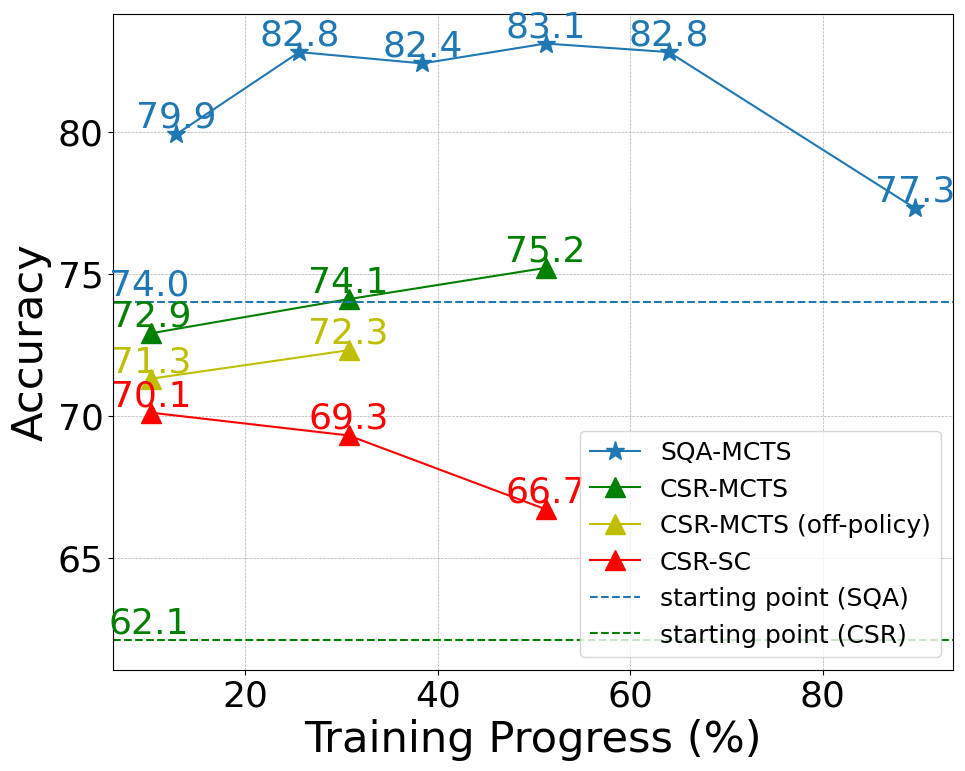

In [66]:
baselines = {
    'starting point (SQA)': 74.0,
    'starting point (CSR)': 62.1,
    # 'social': 48.0,
}

K_plots = {
    'SQA-MCTS': [
        [1024/80, 79.9],
        [2048/80, 82.8],
        [3072/80, 82.4],
        [4096/80, 83.1],
        [5120/80, 82.8],
        [7168/80, 77.3],
    ],
    'CSR-MCTS': [
        [1024/100, 72.9],
        [3072/100, 74.1],
        [5120/100, 75.2],
    ],
    'CSR-MCTS (off-policy)': [
        [1024/100, 71.3],
        [3072/100, 72.3],
    ],
    'CSR-SC': [
        [1024/100, 70.1],
        [3072/100, 69.3],
        [5120/100, 66.7],
    ],
}

shape_k_plot(K_plots, baselines)

In [ ]:
baselines = {
    # 'starting point (SQA)': 74.0,
    # 'starting point (CSR)': 62.1,
    # 'social': 48.0,
}

K_plots = {
    'SQA-MCTS': [
        [1024/80, 79.9],
        [2048/80, 82.8],
        [3072/80, 82.4],
        [4096/80, 83.1],
        [5120/80, 82.8],
        [7168/80, 77.3],
    ],
    'SQA-SC': [
        [1024/80, 79.9],
        [2048/80, 82.8],
        [3072/80, 82.4],
        [4096/80, 83.1],
        [5120/80, 82.8],
        [7168/80, 77.3],
    ],
    'CSR-MCTS': [
        [1024/100, 72.9],
        [3072/100, 74.1],
        [5120/100, 75.2],
    ],
    'CSR-SC': [
        [1024/100, 71.3],
        [3072/100, 72.3],
    ],
    'Arithmetic-MCTS': [
        [1024/200, 70.1],
        [3072/200, 69.3],
        [5120/200, 66.7],
    ],
    'Arithmetic-SC': [
        [1024/200, 70.1],
        [3072/200, 69.3],
        [5120/200, 66.7],
    ],
}

shape_k_plot(K_plots, baselines)

# Analysis

```sh
The supplement of an angle is the angle that, when added to the original angle, forms a straight line (180 degrees).
The complement of an angle is the angle that, when added to the original angle, forms a right angle (90 degrees).
Let the original angle be x degrees. Then its supplement is 180 - x degrees and its complement is 90 - x degrees.
We are told that the supplement is six times the complement, so we have the equation:
180 - x = 6(90 - x)
Simplifying, we get:
180 - x = 540 - 6x
5x = 360
x = 72
Therefore, the measure of the angle is 72 degrees.
The answer is: 72
```

```sh
Let the angle be $x$ degrees. Then its supplement is $180-x$ degrees and its complement is $90-x$ degrees.
The problem tells us that the supplement is six times the complement, so we have the equation $180-x=6(90-x)$.
Simplifying, we get $180-x=540-6x$.
Adding $6x$ to both sides and subtracting 180 from both sides, we get $5x=360$.
Dividing both sides by 5, we get $x=72$.
Therefore, the measure of the angle is $\\boxed{72}$ degrees.
The answer is: 72
```